<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes 
<br>MIT Licensed
<br>Author: Leandro Pessini

# <p style="font-size:100%; text-align:left; color:#444444;">Exploratory Data Analysis (EDA)</p>

# <p style="font-size:100%; text-align:left; color:#444444;">Table of Contents:</p>
* [1. EDA](#1)
  * [1.1 Rentals Data - Moby Bikes](#1.1)
  * [1.2 Weather Data - Met Éireann](#1.2)
  * [1.3 Unusual Observations analysis](#1.2)
* [2. Discrete Analysis (Count Data)](#2)
  * [2.1 Overdispersion](#2.1)
  * [2.2 Zero-inflated](#2.2)
* [2. Probability distribution vs Time Series](#2)
  * [2.1 Time series analysis](#2.1)
  * [2.2 Zero-inflated analysis](#2.2)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import scipy.stats as stats

from statsmodels.stats import diagnostic as diag
import statsmodels.api as sm

%matplotlib inline
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [3]:
%reload_ext watermark
%watermark -a "Leandro Pessini" -n -u -v -iv -w

Author: Leandro Pessini

Last updated: Tue May 03 2022

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 8.3.0

matplotlib : 3.4.2
pandas     : 1.3.0
scipy      : 1.8.0
sys        : 3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:36:15) 
[Clang 11.1.0 ]
numpy      : 1.21.1
seaborn    : 0.11.1
statsmodels: 0.13.2

Watermark: 2.3.0



In [4]:
hourly_data = pd.read_csv('../data/processed/hourly_data.csv')
hourly_rentals = pd.read_csv('../data/processed/hourly_rentals.csv')
all_data = pd.read_csv('../data/processed/all_data.csv')
rentals = pd.read_csv('../data/interim/new_features_rentals.csv')
hourly_data.head()

,rain,temp,rhum,wdsp,date,hour,day,month,year,holiday,...,peak,timesofday,rainfall_intensity,wind_bft,wind_speed_group,temp_r,temp_kbin,temp_kbin_quantile,temp_kbin_kmeans,count
0,0.0,0.1,98,4,2021-03-01,0,1,3,2021,False,...,False,Night,no rain,2,Calm / Light Breeze,0,1.0,0.0,0.0,0
1,0.0,-1.1,98,3,2021-03-01,1,1,3,2021,False,...,False,Night,no rain,2,Calm / Light Breeze,-1,1.0,0.0,0.0,0
2,0.0,-1.2,98,4,2021-03-01,2,1,3,2021,False,...,False,Night,no rain,2,Calm / Light Breeze,-1,1.0,0.0,0.0,1
3,0.0,-0.9,100,5,2021-03-01,3,1,3,2021,False,...,False,Night,no rain,2,Calm / Light Breeze,-1,1.0,0.0,0.0,0
4,0.0,0.0,100,6,2021-03-01,4,1,3,2021,False,...,False,Night,no rain,2,Calm / Light Breeze,0,1.0,0.0,0.0,0


In [5]:
# EDA libraries
# from pandas_profiling import ProfileReport
# from dataprep.eda import create_report
# import sweetviz as sv

# Dataprep Report

# hourly_data_report = create_report(hourly_data, title='Hourly Data Report', progress=False)
# hourly_data_report.save('../reports/dataprep/hourly_data_report')
# hourly_rentals_report = create_report(hourly_rentals, title='Hourly Data Report (Only Rentals)', progress=False)
# hourly_rentals_report.save('../reports/dataprep/hourly_rentals_report')

# Pandas Profiling

# profile = ProfileReport(hourly_data, title='Hourly Data', html={'style':{'full_width':True}})
# profile.to_file(output_file='../reports/pandas-profiling/hourly_data_report.html')

# profile = ProfileReport(hourly_rentals, title='Hourly Data Report (Only Rentals)', html={'style':{'full_width':True}})
# profile.to_file(output_file='../reports/pandas-profiling/hourly_rentals_report.html')

# to_notebook_iframe() will print in the jupyter notebook's cell
# profile.to_notebook_iframe()

# SweetViz

# hourlydata_sweetviz_report = sv.analyze(hourly_data, target_feat='count')
# hourlydata_sweetviz_report.show_html('../reports/sweetviz/hourly_data_report.html')

# hourlyrentals_sweetviz_report = sv.analyze(hourly_rentals, target_feat='count')
# hourlyrentals_sweetviz_report.show_html('../reports/sweetviz/hourly_rentals_report.html')

In [6]:
cat_vars_dict = {'holiday': 'category', 'dayofweek': 'category', 'working_day': 'category', 
            'season': 'category', 'peak': 'category', 'timesofday': 'category', 'rainfall_intensity': 'category'}

hourly_data = hourly_data.astype(cat_vars_dict)
hourly_rentals = hourly_rentals.astype(cat_vars_dict)

## Battery distribution

In [130]:
battery_dist_df = all_data.copy()

def group_battery_status(df):

    bins= [0,30,50,80,100]
    labels = ['< 30%','30% - 50%','50% - 80%','> 80%']
    df['battery_status'] = pd.cut(df['start_battery'], bins=bins, labels=labels, right=False)

    s = df.battery_status
    counts = s.value_counts()
    percent = s.value_counts(normalize=True)
    df_summary = pd.DataFrame({'counts': counts, 'per': percent}, labels)
    df_summary['per100'] = round((df_summary['per']*100),2).astype(str) + '%'
    
    return df_summary

battery_dist = group_battery_status(battery_dist_df)
battery_dist

,counts,per,per100
< 30%,2509,0.076862,7.69%
30% - 50%,5767,0.176669,17.67%
50% - 80%,14290,0.437766,43.78%
> 80%,10077,0.308703,30.87%


### Initial battery density

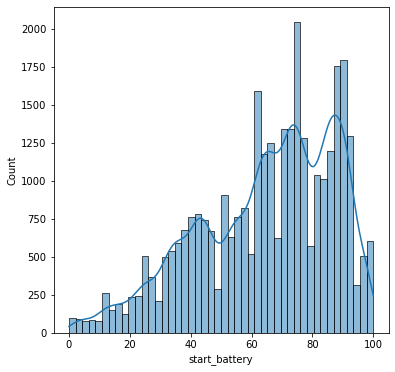

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.histplot(data=rentals, x='start_battery', kde=True)
plt.show()

## Duration of rentals

In [183]:
avg_rental_duration = f"Average rentals duration: {round(all_data['duration'].mean(), 2)} minutes"

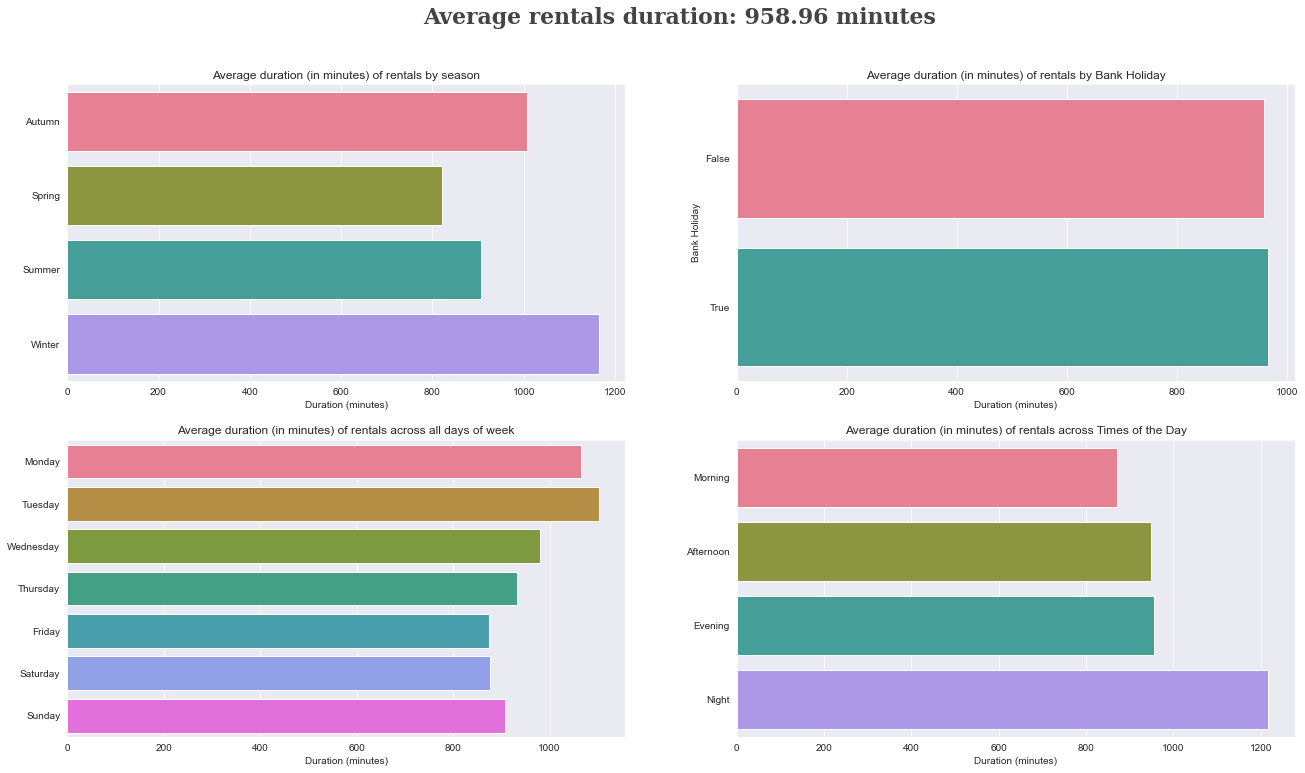

In [184]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(22, 12))

# fig.text(0.125,1.1, avg_rental_duration, fontfamily='serif',fontsize=14, fontweight='bold', color='#444444')
fig.text(0.35,0.95,avg_rental_duration,fontfamily='serif',fontsize=22,fontweight='bold',color='#444444')

season_rentduration = all_data.groupby(['season'])['duration'].mean()
sns.barplot(x=season_rentduration.values, y=season_rentduration.index, ax=ax[0][0], orient='h', palette='husl')
ax[0][0].set(xlabel='Duration (minutes)', ylabel='', title='Average duration (in minutes) of rentals by season')

day_of_week_rentduration = all_data.groupby(['dayofweek'])['duration'].mean()
sns.barplot(x=day_of_week_rentduration.values, y=day_of_week_rentduration.index, ci=None, ax=ax[1][0],
            order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], orient='h', palette='husl')
ax[1][0].set(xlabel='Duration (minutes)', ylabel='', title='Average duration (in minutes) of rentals across all days of week')

holiday_rentduration = all_data.groupby(['holiday'])['duration'].mean()
sns.barplot(x=holiday_rentduration.values, y=holiday_rentduration.index, ax=ax[0][1], orient='h', palette='husl')
ax[0][1].set(xlabel='Duration (minutes)', ylabel='Bank Holiday', title='Average duration (in minutes) of rentals by Bank Holiday')
# ax[0][1].bar_label(ax[0][1].containers[0])

timesofday_rentduration = all_data.groupby(['timesofday'])['duration'].mean()
sns.barplot(x=timesofday_rentduration.values, y=timesofday_rentduration.index, ax=ax[1][1],
            order=['Morning','Afternoon','Evening','Night'], orient='h', palette='husl')
ax[1][1].set(xlabel='Duration (minutes)', ylabel='', title='Average duration (in minutes) of rentals across Times of the Day')

plt.show()

We can spot a few patterns where on colder days (Autumn and Winter | Night) the duration of rentals on average is higher. It seems that, on average, customers stay longer with bikes on early days of the week (Monday, Tuesday and Wednesday). On the other hand, it does not seem to be a difference on average rentals duration on Bank Holidays.

### Rentals by Season

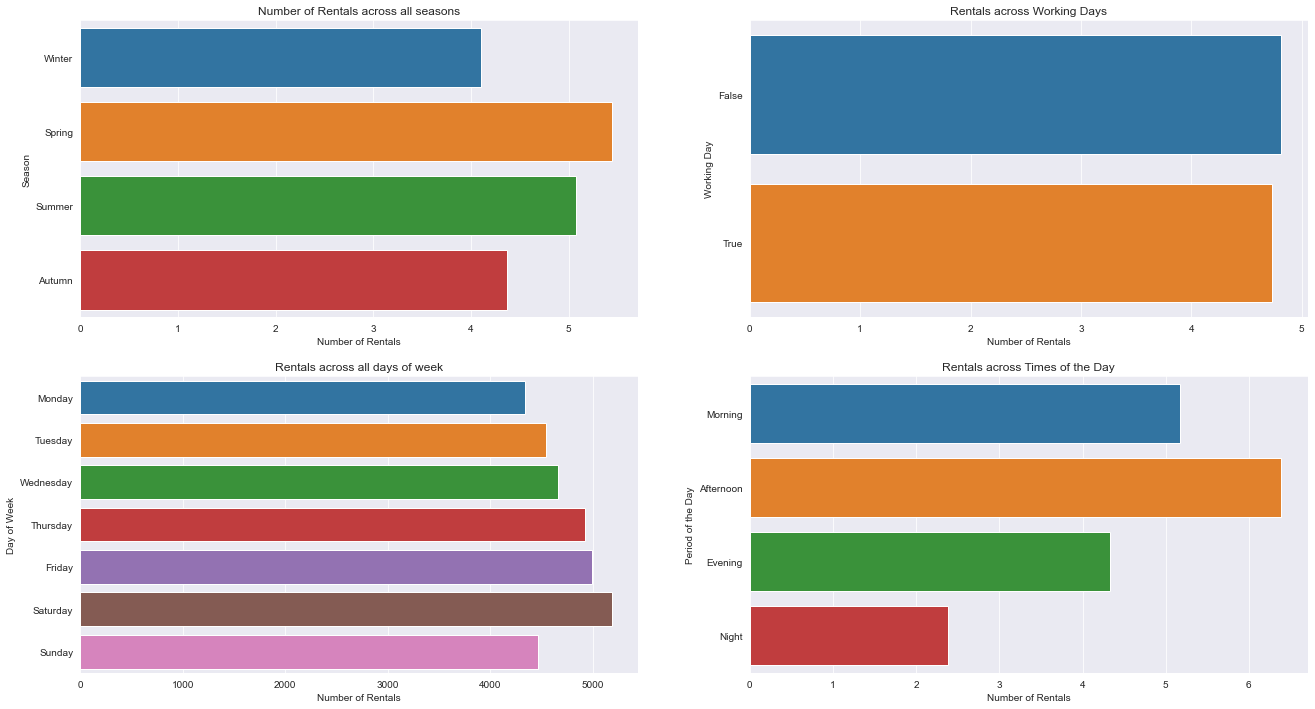

In [86]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(22, 12))

sns.barplot(data=hourly_rentals, 
            x='count', y='season', order=['Winter','Spring','Summer','Autumn'], ci=None, ax=ax[0][0])
ax[0][0].set(xlabel='Number of Rentals', ylabel='Season', title='Number of Rentals across all seasons')

day_of_week = hourly_rentals.groupby('dayofweek')['count'].agg('sum').reset_index(name='count')
sns.barplot(data=day_of_week, x='count', y='dayofweek', ci=None, ax=ax[1][0],
            order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
ax[1][0].set(xlabel='Number of Rentals', ylabel='Day of Week', title='Rentals across all days of week')

sns.barplot(data=hourly_rentals, x='count', y='working_day', ci=None, ax=ax[0][1], orient='h')
# sns.lineplot(data=hourly_rentals , x="hour", y="count", hue="working_day", ax=ax[0][1], ci=None)
ax[0][1].set(xlabel='Number of Rentals', ylabel='Working Day', title='Rentals across Working Days')

sns.barplot(data=hourly_rentals, x='count', y='timesofday', ci=None, ax=ax[1][1],
            order=['Morning','Afternoon','Evening','Night'])
ax[1][1].set(xlabel='Number of Rentals', ylabel='Period of the Day', title='Rentals across Times of the Day')

plt.show()

As expected, in the Spring and Summer had more rentals than on Autumn and Winter as the weather impacts directly the number of rentals and those seasons usually have better weather.



## Hourly Rentals by Days of the Week

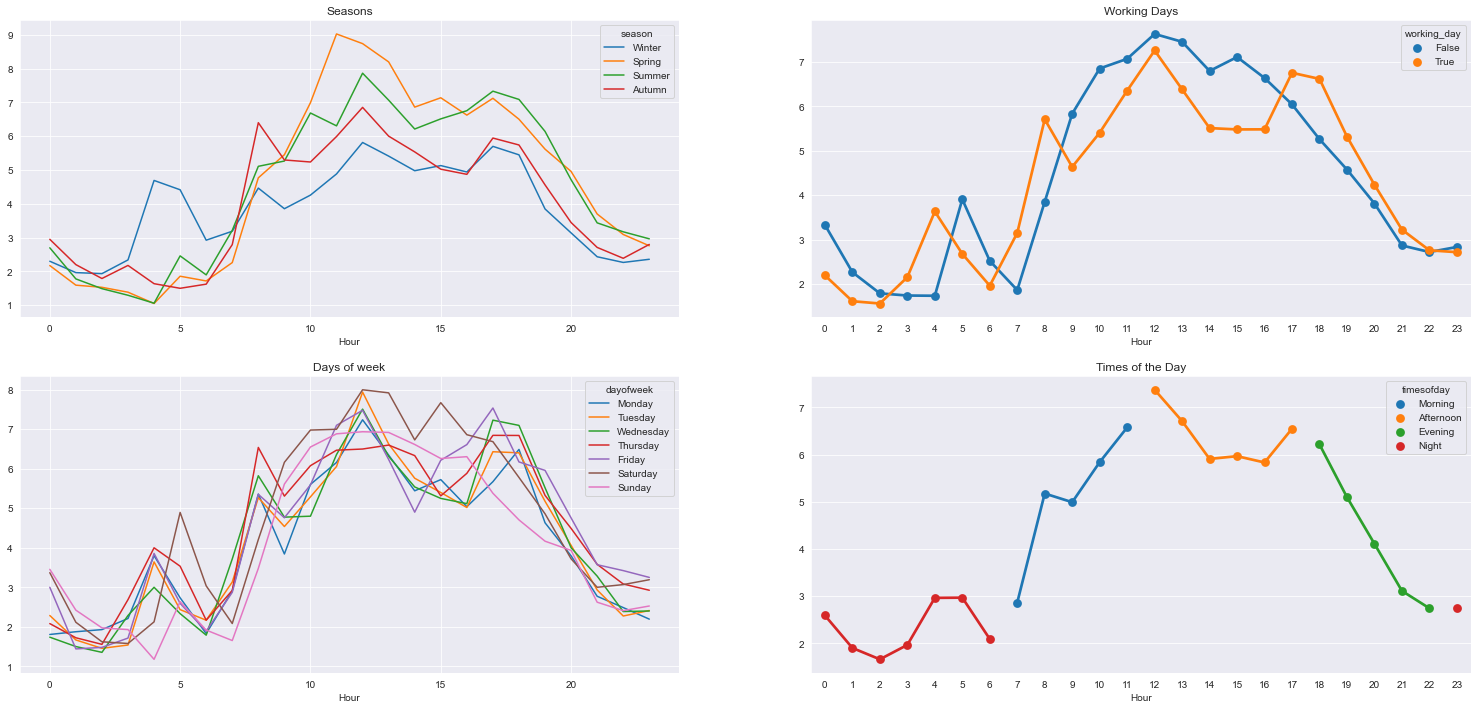

In [104]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(26, 12))

sns.lineplot(data=hourly_rentals, x='hour', y='count', hue='season', hue_order=['Winter','Spring','Summer','Autumn'], ax=ax[0][0], ci=None)
ax[0][0].set(xlabel='Hour', ylabel='', title='Seasons')

sns.lineplot(data=hourly_rentals, x='hour', y='count', hue='dayofweek', hue_order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ax=ax[1][0], ci=None)
ax[1][0].set(xlabel='Hour', ylabel='', title='Days of week')

sns.pointplot(data=hourly_rentals, x="hour", y="count", hue="working_day", ax=ax[0][1], ci=None)
ax[0][1].set(xlabel='Hour', ylabel='', title='Working Days')

sns.pointplot(data=hourly_rentals, x='hour', y='count', hue='timesofday', hue_order=['Morning','Afternoon','Evening','Night'], ax=ax[1][1], ci=None)
ax[1][1].set(xlabel='Hour', ylabel='', title='Times of the Day')

plt.show()

## BoxPlot analysis

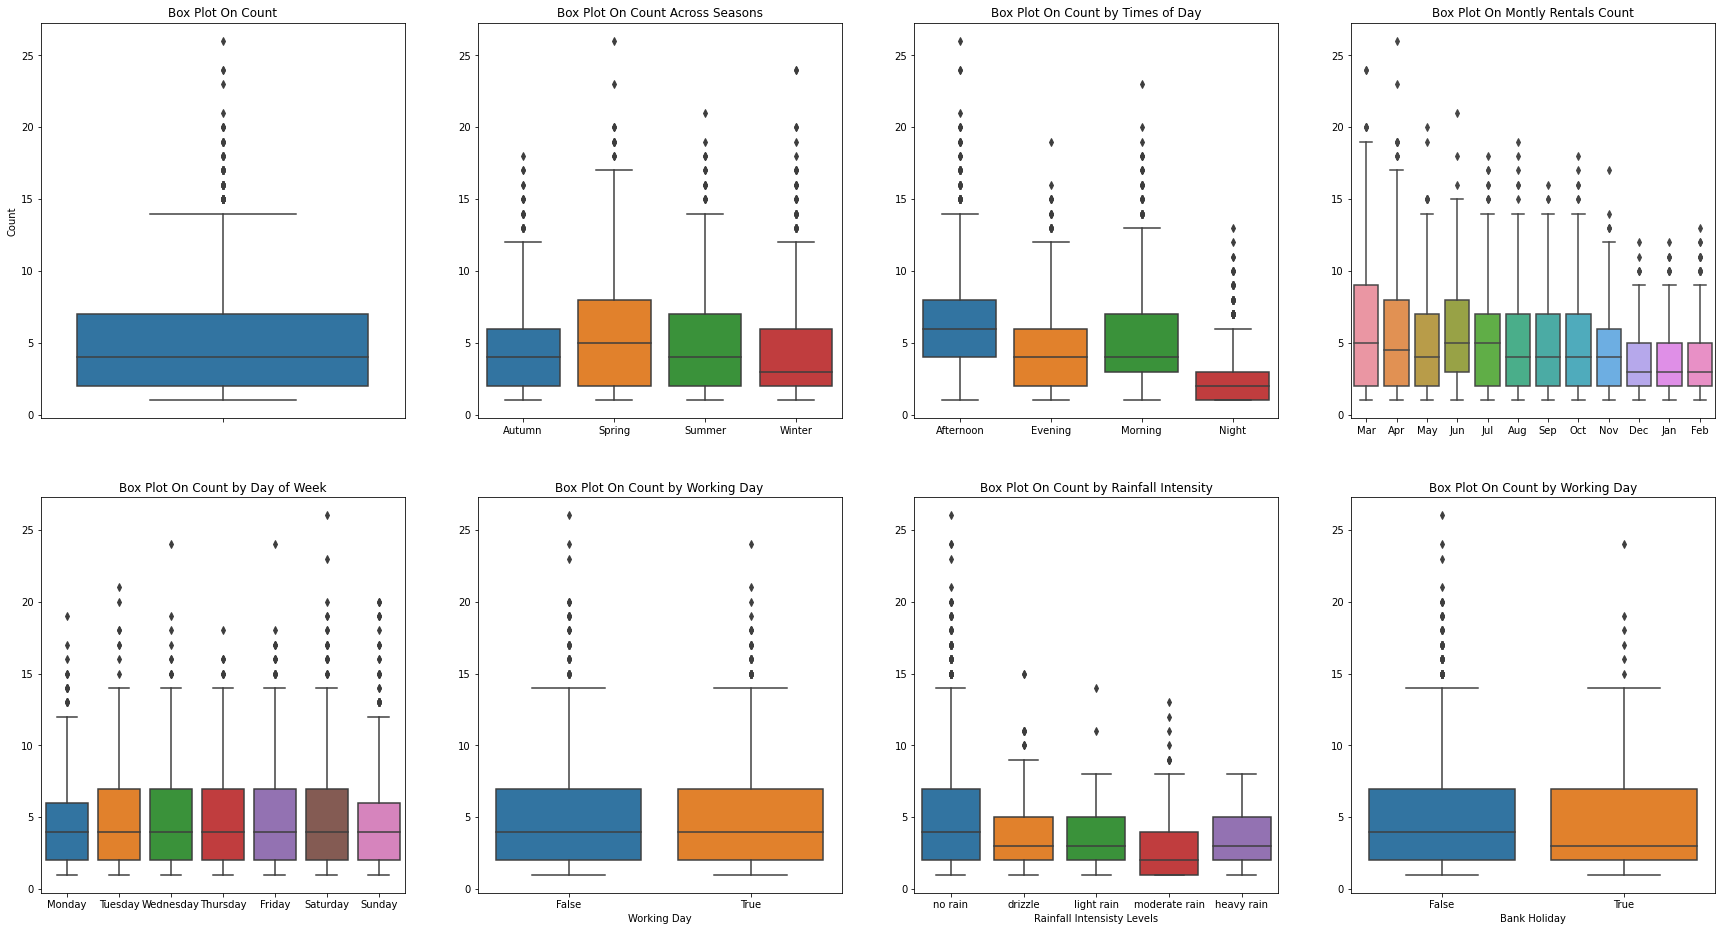

In [15]:
fig, axes = plt.subplots(nrows=2,ncols=4, figsize=(30, 16))

sns.boxplot(data=hourly_rentals,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=hourly_rentals,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=hourly_rentals,y="count",x="dayofweek",orient="v",ax=axes[1][0], 
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
sns.boxplot(data=hourly_rentals,y="count",x="working_day",orient="v",ax=axes[1][1])
sns.boxplot(data=hourly_rentals,y="count",x="timesofday",orient="v",ax=axes[0][2])
sns.boxplot(data=hourly_rentals,y="count",x="rainfall_intensity",orient="v",ax=axes[1][2], 
            order=['no rain', 'drizzle', 'light rain', 'moderate rain', 'heavy rain'])

monthly_data = hourly_rentals[['month','count']].copy()
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
monthly_data['month_str'] = hourly_rentals['month'].map(lambda d : month_map[d])
sns.boxplot(data=monthly_data, x="month_str", y="count", orient="v",ax=axes[0][3])
sns.boxplot(data=hourly_rentals, x="holiday", y="count", orient="v",ax=axes[1][3])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='', ylabel='',title="Box Plot On Count Across Seasons")
axes[1][0].set(xlabel='', ylabel='',title="Box Plot On Count by Day of Week")
axes[1][1].set(xlabel='Working Day', ylabel='',title="Box Plot On Count by Working Day")
axes[0][2].set(xlabel='', ylabel='',title="Box Plot On Count by Times of Day")
axes[1][2].set(xlabel='Rainfall Intensisty Levels', ylabel='',title="Box Plot On Count by Rainfall Intensity")
axes[0][3].set(xlabel='', ylabel='', title="Box Plot On Montly Rentals Count")
axes[1][3].set(xlabel='Bank Holiday', ylabel='', title="Box Plot On Count by Working Day")

plt.show()

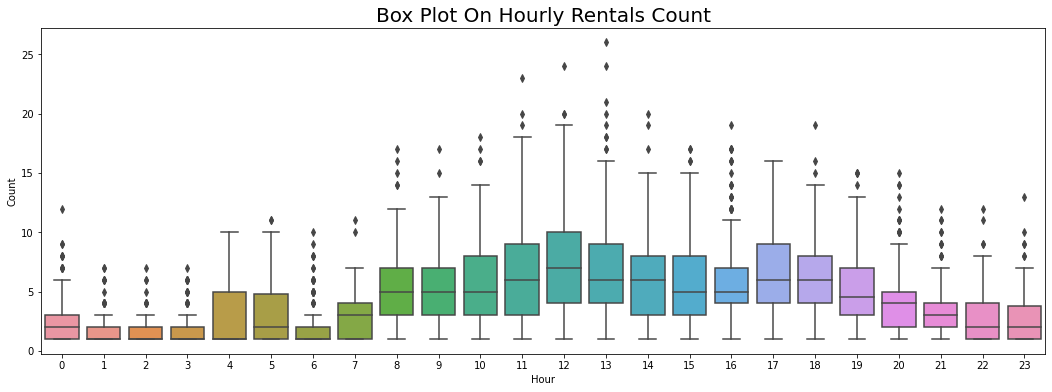

In [16]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(data=hourly_rentals, x="hour", y="count", orient="v",ax=ax)
ax.set(xlabel='Hour', ylabel='Count')
ax.set_title(fontsize=20, label="Box Plot On Hourly Rentals Count")
plt.show()

## Kruskal-Wallis H-test on categorical features

The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid.

- The samples are independent.
- Each sample is from a normally distributed population.
- The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

>*count* feature does not have normal distribution, using non-parametric Kruskal-Wallis H-test instead

In [17]:
# Defining a function to find the statistical relationship with all the categorical variables
def kruskal_test_categorical_features(df, target, cat_vars):
    from scipy.stats import kruskal

    # Creating an empty list of final selected predictors
    selected_predictors=[]
    
    print('##### Kruskal-Wallis H-test Results ##### \n')
    for predictor in cat_vars:
        cat_grouplist=df.groupby(predictor)[target].apply(list)
        kruskal_res = kruskal(*cat_grouplist) #  Kruskal-Wallis H-test
        
        # If the ANOVA P-Value is <0.05, that means we reject H0
        if (kruskal_res[1] < 0.05):
            print(predictor, 'is correlated with', target, '| p-value:', kruskal_res[1])
            selected_predictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', target, '| p-value:', kruskal_res[1])
    
    return(selected_predictors)

In [18]:
# Calling the function to check which categorical variables are correlated with target
cat_vars=['season', 'hour', 'holiday', 'working_day', 'peak', 'timesofday', 'rainfall_intensity']
kruskal_test_categorical_features(df=hourly_rentals, target='count', cat_vars=cat_vars)

##### Kruskal-Wallis H-test Results ##### 

season is correlated with count | p-value: 8.63495056716637e-31
hour is correlated with count | p-value: 0.0
holiday is NOT correlated with count | p-value: 0.41942955527875236
working_day is NOT correlated with count | p-value: 0.15009923596080033
peak is correlated with count | p-value: 1.0653072805746697e-28
timesofday is correlated with count | p-value: 0.0
rainfall_intensity is correlated with count | p-value: 2.880235646944005e-24


['season', 'hour', 'peak', 'timesofday', 'rainfall_intensity']

## Correlation Matrix

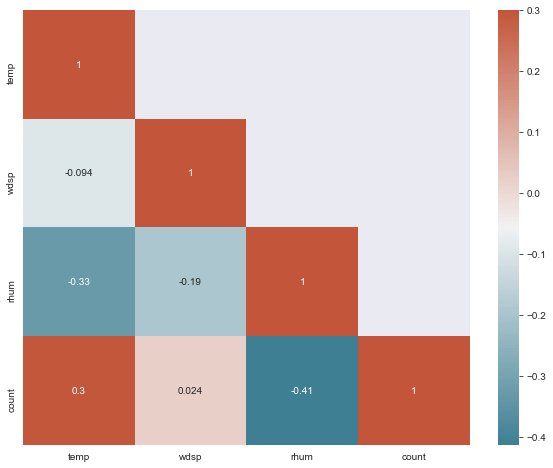

,Correlation to the target
temp,0.297142
wdsp,0.023791
rhum,-0.413528


In [162]:
corrMatt = hourly_rentals[['temp','wdsp','rhum','count']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
cmap = sns.diverging_palette(220, 20, as_cmap=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corrMatt, mask=mask,vmax=.3, annot=True, ax=ax, cmap=cmap)
plt.show()

df1Corr=pd.DataFrame(corrMatt.drop('count').unstack().sort_values(ascending=False)['count'],columns=['Correlation to the target'])
df1Corr.style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))

## Distribution of numerical features

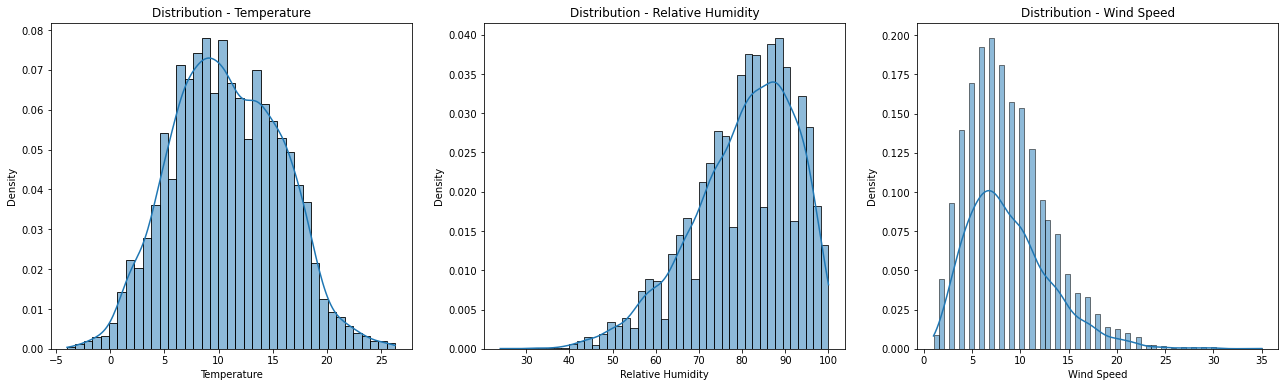

In [21]:
fig = plt.figure(figsize=(22,6))
gs = fig.add_gridspec(1, 3)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

sns.histplot(hourly_rentals['temp'],ax=ax0, stat='density', kde=True)
sns.histplot(hourly_rentals['rhum'],ax=ax1, stat='density', kde=True)
sns.histplot(hourly_rentals['wdsp'],ax=ax2, stat='density', kde=True)

ax0.set(xlabel='Temperature',title="Distribution - Temperature")
ax1.set(xlabel='Relative Humidity',title="Distribution - Relative Humidity")
ax2.set(xlabel='Wind Speed',title="Distribution - Wind Speed")

plt.show()

## Relations between Numerical Features and Target variable

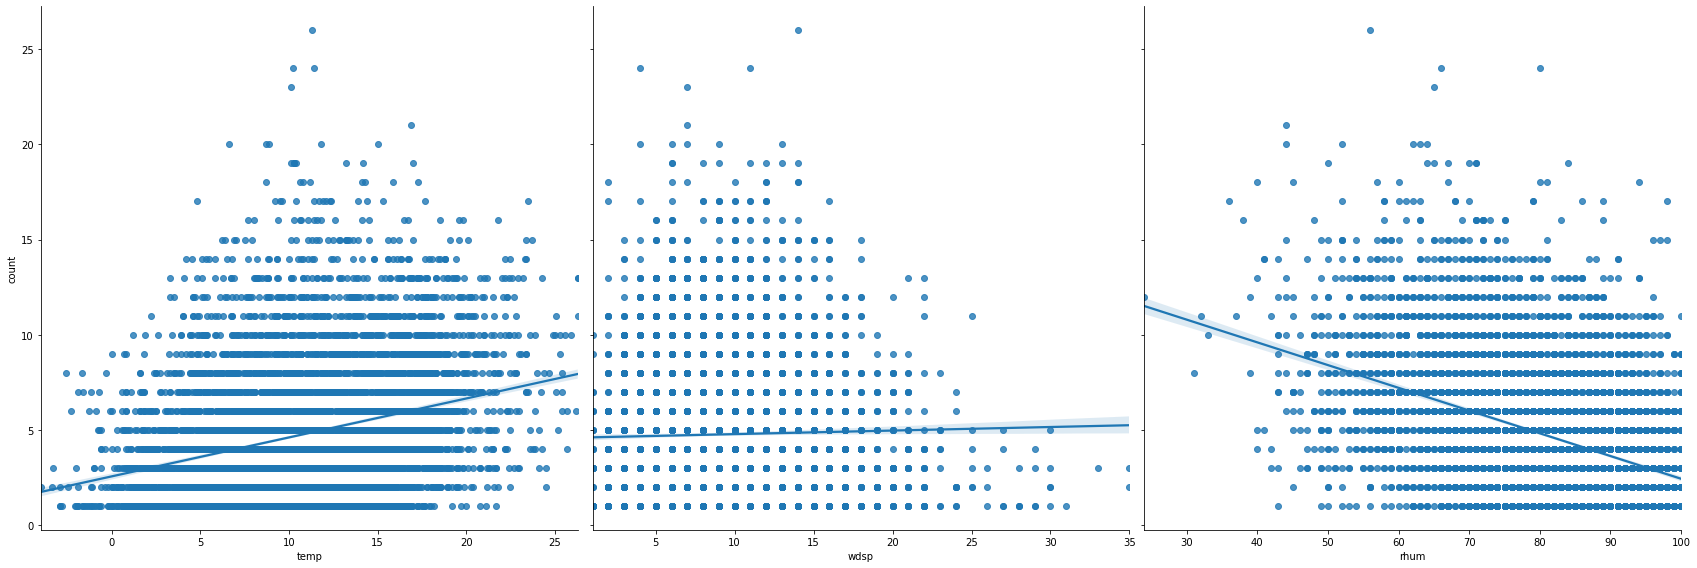

In [22]:
sns.pairplot(hourly_rentals, 
             x_vars=['temp','wdsp','rhum'],
             dropna=True, 
             y_vars='count', 
             height=8, 
             kind="reg", 
             palette='Set1')
plt.show()

Temperature and Relative Humidity show a strong correlation with Rentals Count (positive and negative, respectively) but Wind Speed does not seem to be correlated with Rentals Count. 

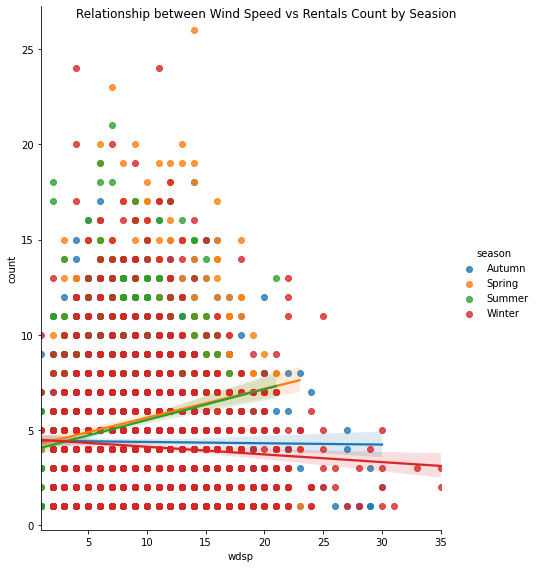

In [23]:
pp = sns.pairplot(hourly_rentals, 
             x_vars='wdsp',
             dropna=True, 
             y_vars='count', height=8, aspect=0.8, kind="reg", hue='season')
pp.fig.suptitle("Relationship between Wind Speed vs Rentals Count by Seasion")
plt.show()

If we plot the relationship by Season we can see that Wind Speed is correlated but depending on the Season is positive or negative. Which makes sense since on Autumn and Winter, as it is colder and temperature is normally low, Rentals decrease as the Wind Speed increases. In the Spring and Summer, because the temperature are on average higher the wind speed we see a different effect (positive correlation).



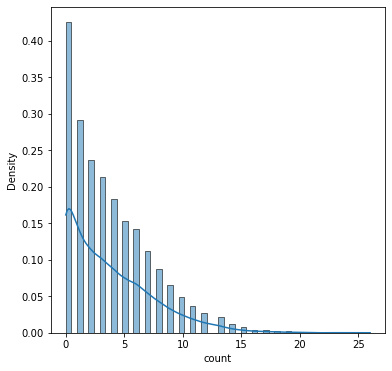

In [24]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.histplot(data=hourly_data, x='count', stat='density', kde=True)
plt.show()

## Outlier Analysis

In [25]:
hourly_rentals['count'].describe()

count    6966.000000
mean        4.754378
std         3.442080
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        26.000000
Name: count, dtype: float64

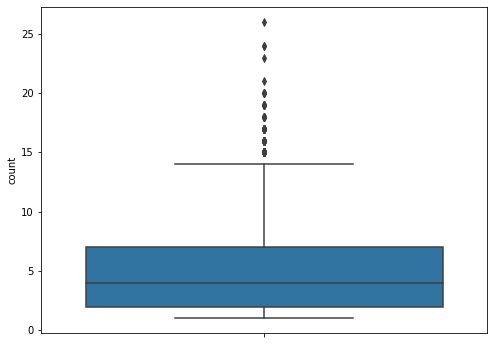

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=hourly_rentals,
            y="count",
            orient="v",ax=ax)
plt.show()

In [27]:
hourlyDataOutliers = hourly_rentals[hourly_rentals['count'] > 14]
hourlyDataWithoutOutliers = hourly_rentals[hourly_rentals['count'] <= 14]
    
print(f"Outliers (#): {round(hourlyDataOutliers.shape[0], 2)}")
print(f"Outliers (%): {round((hourlyDataOutliers.shape[0] / hourly_rentals.shape[0])*100, 2)}%")

Outliers (#): 93
Outliers (%): 1.34%


In [28]:
hourlyDataOutliers['holiday'].value_counts()

False    87
True      6
Name: holiday, dtype: int64

In [29]:
hourlyDataOutliers['working_day'].value_counts(normalize=True)

False    0.505376
True     0.494624
Name: working_day, dtype: float64

In [30]:
hourlyDataOutliers['season'].value_counts()

Spring    45
Winter    21
Summer    18
Autumn     9
Name: season, dtype: int64

Unusual observations do not seem to be related with *Holiday* nor Weekends (*Working_Day*). 

In [31]:
daily_count = hourly_rentals.groupby('date')['count'].sum().reset_index()
daily_count_no_outliers = hourlyDataWithoutOutliers.groupby('date')['count'].sum().reset_index()

In [32]:
mean_daily = daily_count['count'].mean()
std_dev_daily = daily_count['count'].std()
slice_daily = mean_daily + (2*std_dev_daily)
daily_count[daily_count['count'] > slice_daily]

,date,count
6,2021-03-07,157
16,2021-03-17,171
18,2021-03-19,151
19,2021-03-20,148
33,2021-04-03,155
47,2021-04-17,153
54,2021-04-24,163
55,2021-04-25,168
138,2021-07-17,162
144,2021-07-23,154


In [33]:
daily_count.describe()

,count
count,364.000000
mean,90.986264
std,27.873234
min,14.000000
25%,73.000000
50%,90.000000
75%,111.000000
max,171.000000


In [34]:
print(f"Mean of daily rentals = {round(daily_count['count'].mean(), 2)}")
print(f"Mean of daily rentals without Outliers = {round(daily_count_no_outliers['count'].mean(), 2)}")

Mean of daily rentals = 90.99
Mean of daily rentals without Outliers = 86.67


In [35]:
hourlyDataOutliers = hourlyDataOutliers.join(daily_count.set_index('date'), on='date', lsuffix='_hour', rsuffix='_day')

In [36]:
outliers_df = hourlyDataOutliers[hourlyDataOutliers['count_day'] > 110].sort_values(by='count_day', ascending=False)
outliers_df.head()

,date,hour,rain,temp,rhum,wdsp,day,month,year,holiday,...,timesofday,rainfall_intensity,wind_bft,wind_speed_group,temp_r,temp_kbin,temp_kbin_quantile,temp_kbin_kmeans,count_hour,count_day
286,2021-03-17,11,0.0,8.7,81,12,17,3,2021,True,...,Morning,no rain,4,Moderate Breeze,9,4.0,4.0,4.0,18,171
287,2021-03-17,12,0.0,10.3,71,9,17,3,2021,True,...,Afternoon,no rain,3,Breeze,10,4.0,5.0,4.0,19,171
288,2021-03-17,13,0.0,11.4,66,11,17,3,2021,True,...,Afternoon,no rain,4,Moderate Breeze,11,5.0,6.0,5.0,24,171
289,2021-03-17,14,0.0,11.9,60,12,17,3,2021,True,...,Afternoon,no rain,4,Moderate Breeze,12,5.0,6.0,5.0,17,171
290,2021-03-17,15,0.0,12.8,49,10,17,3,2021,True,...,Afternoon,no rain,3,Breeze,13,5.0,6.0,5.0,15,171


> Outliers plots: https://www.kirenz.com/post/2021-11-14-linear-regression-diagnostics-in-python/linear-regression-diagnostics-in-python/

In [37]:
hourlyDataOutliers.to_csv('../data/interim/outliers.csv')

In [38]:
all_data = pd.read_csv('../data/processed/all_data.csv')
all_data[["date"]] = all_data[["date"]].apply(pd.to_datetime)
all_data['month_year'] = pd.to_datetime(all_data['date']).dt.to_period('M')
df_month = all_data.groupby("month_year").agg({"bikeid": pd.Series.nunique})
df_month

,bikeid
month_year,
2021-03,94
2021-04,79
2021-05,78
2021-06,78
2021-07,77
2021-08,72
2021-09,75
2021-10,75
2021-11,73


## Monthly Data

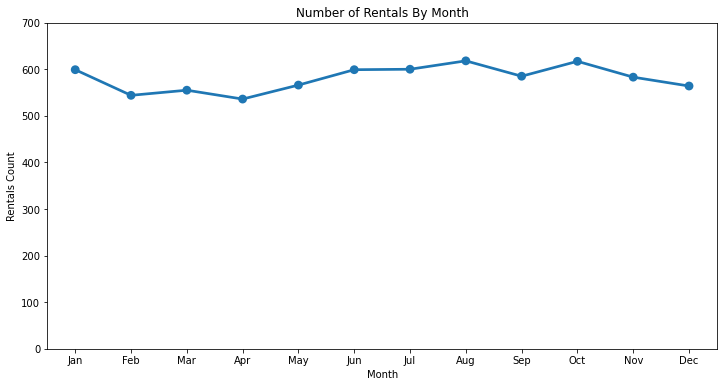

In [39]:
monthly_data = hourly_rentals.groupby('month')['count'].agg('count').reset_index(name='count')
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
monthly_data['monthly_data_str'] = monthly_data['month'].map(lambda d : month_map[d])
fig, ax = plt.subplots(figsize=(12, 6))
sns.pointplot(x=monthly_data["monthly_data_str"], 
              y=monthly_data["count"],
              ax=ax)
ax.set(xlabel='Month', ylabel='Rentals Count', title="Number of Rentals By Month")
ax.set(ylim=(0,700))
plt.show()

## Daily Data - Time Series

In [40]:
time_series_df = hourly_data.copy()
slice_daily_data = time_series_df[['date', 'holiday', 'dayofweek', 'working_day', 'season']]
time_series_df = time_series_df.groupby('date')['count'].agg('sum').reset_index(name='count')
time_series_df = pd.merge(time_series_df, slice_daily_data, on='date', how='left')
# time_series_df['datetime'] = pd.to_datetime(time_series_df.date) + pd.to_timedelta(time_series_df.hour, unit='h')
time_series_df['datetime'] = pd.to_datetime(time_series_df.date)
time_series_df.set_index('datetime', inplace=True)
time_series_df = time_series_df[~time_series_df.index.duplicated(keep='first')]
time_series_df.drop(time_series_df.tail(1).index,inplace=True)

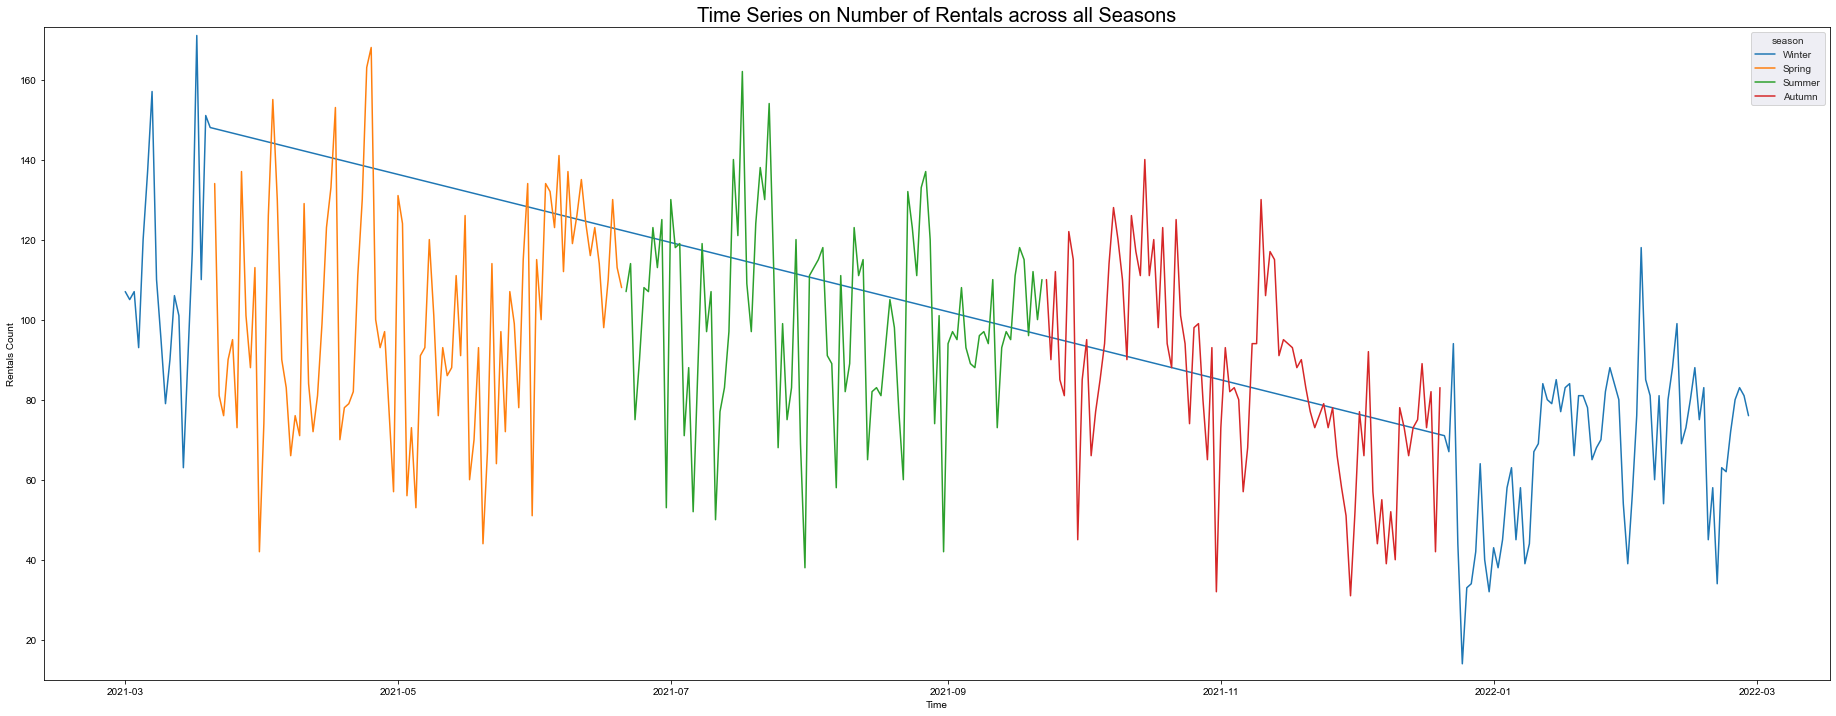

In [41]:
fig, ax = plt.subplots(figsize=(32, 12))
sns.set_style("darkgrid")
sns.lineplot(x=time_series_df.index, 
              y=time_series_df["count"], 
              hue=time_series_df["season"],
              hue_order=['Winter','Spring','Summer','Autumn'],
              ax=ax)
ax.set(xlabel='Time', ylabel='Rentals Count')
ax.set(ylim=(10,max(time_series_df["count"])+2))
ax.set_title(fontsize=20, label="Time Series on Number of Rentals across all Seasons")
plt.show()

## Zero-inflated problem

In [42]:
zero_values = len(hourly_data[hourly_data['count'] == 0])
print(f"Zeros (#): {round(zero_values, 2)}")
print(f"Zeros (%): {round((zero_values/hourly_data.shape[0])*100, 2)}%")

Zeros (#): 1794
Zeros (%): 20.48%


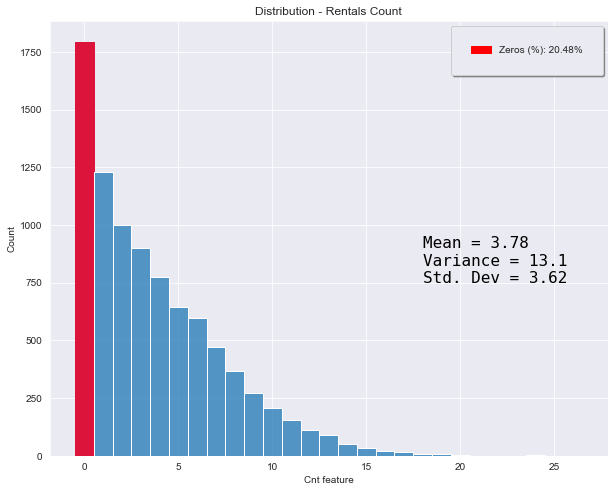

In [43]:
zero_percent = f"Zeros (%): {round((zero_values/hourly_data.shape[0])*100, 2)}%"
stats_df = hourly_data['count'].agg(['mean','var','std'])
label_stats = \
    f"Mean = {round(stats_df['mean'], 2)} \nVariance = {round(stats_df['var'], 2)} \nStd. Dev = {round(stats_df['std'], 2)}"
fig, ax = plt.subplots(figsize=(10, 8))
distri_plot = sns.histplot(data=hourly_data, x='count', ax=ax, stat='count', discrete=True)
ax.set(xlabel='Cnt feature',title="Distribution - Rentals Count")
red_patch = mpatches.Patch(color='red', label=zero_percent)
plt.legend(handles=[red_patch], fancybox=True, framealpha=1, shadow=True, borderpad=2)
heights = [p.get_height() for p in ax.patches]
highest = sorted(heights)[-1]
for p in ax.patches:
    if  p.get_height() >= highest:
        p.set_color('crimson')
distri_plot.annotate(label_stats,xy=(18, 750),fontsize=16,fontfamily='monospace', color='black')
plt.show()

### Distribution across Times of the Day

In [44]:
def labels_zeros(df):
    zero_values = len(df[df['count'] == 0])
    stats_df = df['count'].agg(['mean','var','std'])
    return f"Zeros: {round((zero_values/df.shape[0])*100, 2)}% \n" + \
        f"Mean = {round(stats_df['mean'], 2)} \nVariance = {round(stats_df['var'], 2)} \nStd. Dev = {round(stats_df['std'], 2)} \n" +\
        f"n = {df.shape[0]}"

df_night = hourly_data[hourly_data['timesofday'] == 'Night']
df_morn = hourly_data[hourly_data['timesofday'] == 'Morning']
df_aft = hourly_data[hourly_data['timesofday'] == 'Afternoon']
df_eve = hourly_data[hourly_data['timesofday'] == 'Evening']

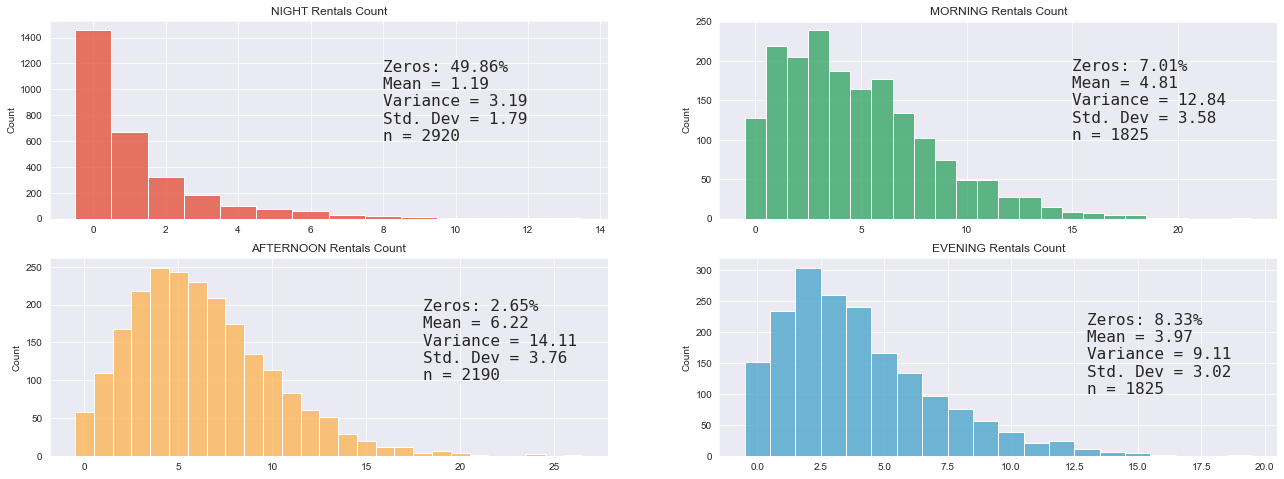

In [45]:
fig = plt.figure(figsize=(22,8))
gs = fig.add_gridspec(2, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

night_plot = sns.histplot(data=df_night, x='count', ax=ax0, stat='count', discrete=True, color='#e34a33')
morning_plot = sns.histplot(data=df_morn, x='count', ax=ax1, stat='count', discrete=True, color='#2ca25f')
afternoon_plot = sns.histplot(data=df_aft, x='count', ax=ax2, stat='count', discrete=True, color='#feb24c')
evening_plot = sns.histplot(data=df_eve, x='count', ax=ax3, stat='count', discrete=True, color='#43a2ca')

night_plot.annotate(labels_zeros(df_night), xy=(8, 600), fontsize=16, fontfamily='monospace')
label_stats = labels_zeros(df_morn)
morning_plot.annotate(labels_zeros(df_morn), xy=(15, 100), fontsize=16, fontfamily='monospace')
label_stats = labels_zeros(df_aft)
afternoon_plot.annotate(labels_zeros(df_aft), xy=(18, 100), fontsize=16, fontfamily='monospace')
label_stats = labels_zeros(df_eve)
evening_plot.annotate(labels_zeros(df_eve), xy=(13, 100), fontsize=16, fontfamily='monospace')

ax0.set(xlabel='',title="NIGHT Rentals Count")
ax1.set(xlabel='',title="MORNING Rentals Count")
ax2.set(xlabel='',title="AFTERNOON Rentals Count")
ax3.set(xlabel='',title="EVENING Rentals Count")

plt.show()

## None rentals (zeroes)

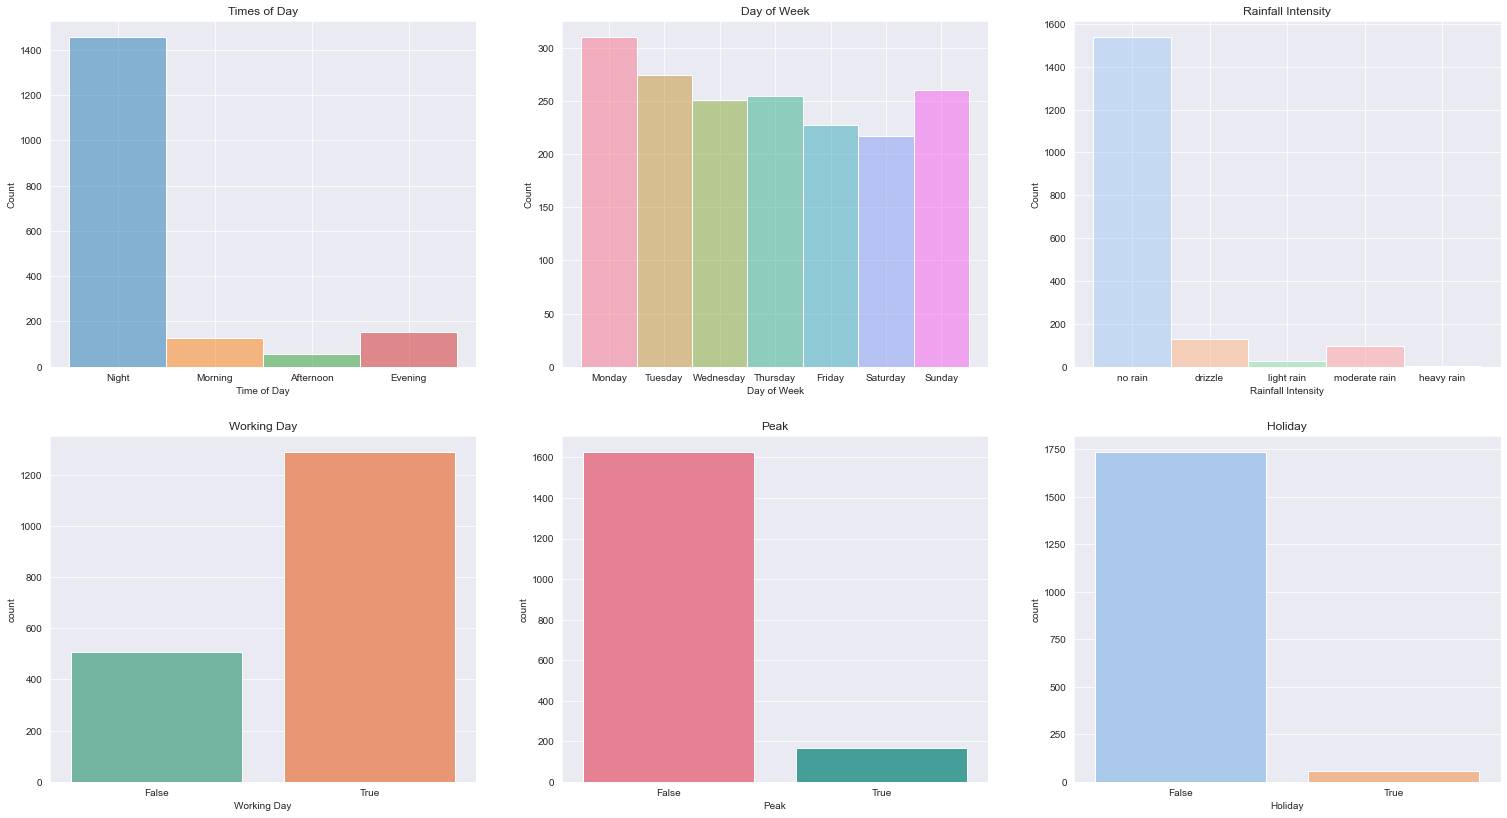

In [46]:
zerocnt_df = hourly_data[hourly_data['count'] == 0].copy()
fig, axes = plt.subplots(nrows=2,ncols=3)
fig.set_size_inches(26, 14)

zerocnt_df['timesofday'] = pd.Categorical(zerocnt_df['timesofday'],['Night','Morning','Afternoon','Evening'])
zerocnt_df['rainfall_intensity'] = pd.Categorical(zerocnt_df['rainfall_intensity'],['no rain','drizzle','light rain','moderate rain','heavy rain'])
zerocnt_df['dayofweek'] = pd.Categorical(zerocnt_df['dayofweek'],['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

# First row
sns.histplot(data=zerocnt_df, x='timesofday', stat='count', ax=axes[0][0], hue='timesofday', palette='tab10', legend=False)
sns.histplot(data=zerocnt_df, x='dayofweek', stat='count', ax=axes[0][1], hue='dayofweek', palette='husl', legend=False)
sns.histplot(data=zerocnt_df, x='rainfall_intensity', stat='count', ax=axes[0][2], hue='rainfall_intensity', palette='pastel', legend=False)
axes[0][0].set(xlabel='Time of Day',title="Times of Day")
axes[0][1].set(xlabel='Day of Week',title="Day of Week")
axes[0][2].set(xlabel='Rainfall Intensity',title="Rainfall Intensity")

# Second row
sns.countplot(data=zerocnt_df, x='working_day', ax=axes[1][0], palette='Set2')
sns.countplot(data=zerocnt_df, x='peak', ax=axes[1][1], palette='husl')
sns.countplot(data=zerocnt_df, x='holiday', ax=axes[1][2], palette='pastel')
axes[1][0].set(xlabel='Working Day',title="Working Day")
axes[1][1].set(xlabel='Peak',title="Peak")
axes[1][2].set(xlabel='Holiday',title="Holiday")

plt.show()

# Conclusion & Discussion

## Overdispersion

In [47]:
descriptive_stats = pd.DataFrame({'Statistics': hourly_data['count'].describe(percentiles=[.1, .25, .5, .75, .9])})
descriptive_stats.loc['variance'] = hourly_data['count'].var()
print(f"Mean {round(descriptive_stats.loc['mean'][0], 2)}"+"\n"+f"Variance {round(descriptive_stats.loc['variance'][0], 2)}")

Mean 3.78
Variance 13.1


One assumption of a Poisson distribution is that the `Mean` = `Variance`. As we can see this is not the case ($Var > Mean$).

### Cameron and Trivedi’s (CT) (1990) test

It is based on the assumption that under the Poisson model ${(y-E[y])^2 –E[y]}$ has zero mean:

`H0`: (Poisson Model correct): $Var[yi] = E[yi]$
<br>`HA`: $Var[yi] = E[yi] +α g(E[yi])$

> CT’s rule of thumb: If $Var[yi] / E[yi] > 2$ => **overdispersion**

In [48]:
print(f'{round(hourly_data["count"].var() / hourly_data["count"].mean(), 2)} => overdispersion found.')

3.47 => overdispersion found.


As a consequence of overdispersed data, we need to fit some other kind of model to the data, accounting for dispersion. Quasi-Poisson and Negative binomial regression are models that deal with over-dispersion.

But if you observe the data set contains an excess of zeroes. If you use a standard Poisson or NB regression model on such data sets, it can fit badly and will generate poor quality predictions, no matter how much you tweak its parameters. 

Fortunately, there is a way to modify a standard counts model such as Poisson or Negative Binomial to account for the presence of the extra zeroes. In fact, there happen to be at least two ways to do this. One technique is known as the Hurdle model and the second technique is known the Zero-Inflated model.

## Zero-inflated (ZI) models

The *hurdle model* or *two-part model* relaxes the assumption that the zeros and the positives come from the same data generating process. A hurdle model has the interpretation that it reflects a two-stage decision-making process. For example, a patient may initiate the first visit to a doctor, but the second and subsequent visits may be determined by a different mechanism. This model works in two steps: 

- In the first step it uses binary classification to discriminate between the zero values and the positive values, 
- and in the second step uses the traditional (poisson or NB) model for positive values.

Zero-inflated negative binomial (ZINB) or Zero-inflated Poisson (ZIP) are models that apply the two-stage process from hurdle models under the hood.

<!-- Zero-inflated Poisson (ZIP)
Hurdle Poisson (HUP)
Negative binomial (NB)
Zero-inflated negative binomial (ZINB)
Hurdle negative binomial (HUNB) -->

## Poisson/NB vs Time series of count data

If a time series of count data is generated by a Poisson point process then event occurrences in successive time intervals are independent. Independence is a reasonable assumption when the underlying stochastic process for events, conditional on covariates, has no memory. Then there is no need for special time series models. For example, the number of deaths (or births) in a region may be uncorrelated over time. At the same time the population, which cumulates births and deaths, will be very highly correlated over time. 

The first step for time series count data is therefore to test for serial correlation.

In [49]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.formula.api import glm
expr = """ count ~ temp_kbin_kmeans + wind_speed_group + rainfall_intensity + holiday + timesofday"""
y_train, X_train = dmatrices(expr, hourly_data, return_type = 'dataframe')
nb_training_results = sm.GLM(y_train, X_train, family = sm.families.NegativeBinomial(alpha = 1)).fit(maxiter=5000, method='nm', cov_type='HC3')
print(nb_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                 8760
Model:                            GLM   Df Residuals:                     8746
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                            nm   Log-Likelihood:                -20069.
Date:                Tue, 03 May 2022   Deviance:                       6158.3
Time:                        11:25:47   Pearson chi2:                 5.93e+03
No. Iterations:                   550   Pseudo R-squ. (CS):             0.2750
Covariance Type:                  HC3                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [50]:
# print(f'AIC: {round(nb_training_results.aic,2)} \nBIC: {round(nb_training_results.bic,2)}')

### Durbin-Watson statistic

> https://www.statology.org/durbin-watson-test-python/

The Durbin-Watson statistic will always have a value ranging between 0 and 4. A value of 2.0 indicates there is no autocorrelation detected in the sample. Values from 0 to less than 2 point to positive autocorrelation and values from 2 to 4 means negative autocorrelation.

In [51]:
from statsmodels.stats.stattools import durbin_watson
# The response residuals are defined as endog - fittedvalues

# The hypotheses followed for the Durbin Watson statistic:
# H(0) = First-order autocorrelation does not exist.
# H(1) = First-order autocorrelation exists.

print(f'Durbin-Watson test for serial correlation: {round(durbin_watson(nb_training_results.resid_response),2)}')

Durbin-Watson test for serial correlation: 1.32


**Possible positive autocorrelation**

A rule of thumb is that DW test statistic values in the range of 1.5 to 2.5 are relatively normal. Values outside this range could, however, be a cause for concern. Field(2009) suggests that values under 1 or more than 3 are a definite cause for concern.

>Field, A. (2009). Discovering Statistics Using SPSS, 3rd Edition (Introducing Statistical Methods) (3rd ed.). SAGE Publications Ltd.

In [52]:
residuals = nb_training_results.resid_response
ljungbox_test = diag.acorr_ljungbox(residuals , auto_lag=True, boxpierce=True)
print(f"Mean of Residuals {np.mean(residuals)}")
print(f'Ljung-Box test p-value: {min(ljungbox_test["lb_pvalue"])}')
print(f'Box-Pierce test p-value: {min(ljungbox_test["bp_pvalue"])}')

Mean of Residuals 0.004949364548379627
Ljung-Box test p-value: 0.0
Box-Pierce test p-value: 0.0


In [53]:
houlyTM = hourly_data[['date','hour','count']].copy()
# houlyTM = hourly_rentals[['date','hour','count']].copy()
houlyTM['datetime'] = pd.to_datetime(houlyTM.date) + pd.to_timedelta(houlyTM.hour, unit='h')
houlyTM.set_index('datetime', inplace=True)
houlyTM.drop(houlyTM.tail(25).index,inplace=True)

### Residual Autocorrelation 

Autocorrelation occurs when the residuals are not independent of each other.

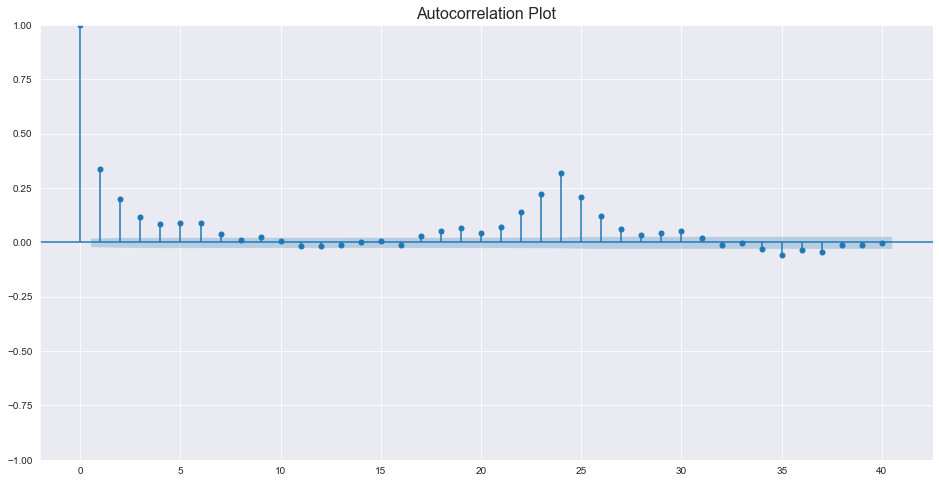

In [54]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(16, 8))
plot_acf(nb_training_results.resid_response, ax=ax)
ax.set_title(label="Autocorrelation Plot", fontsize=16)
plt.show()

### Residual Partial Autocorrelation

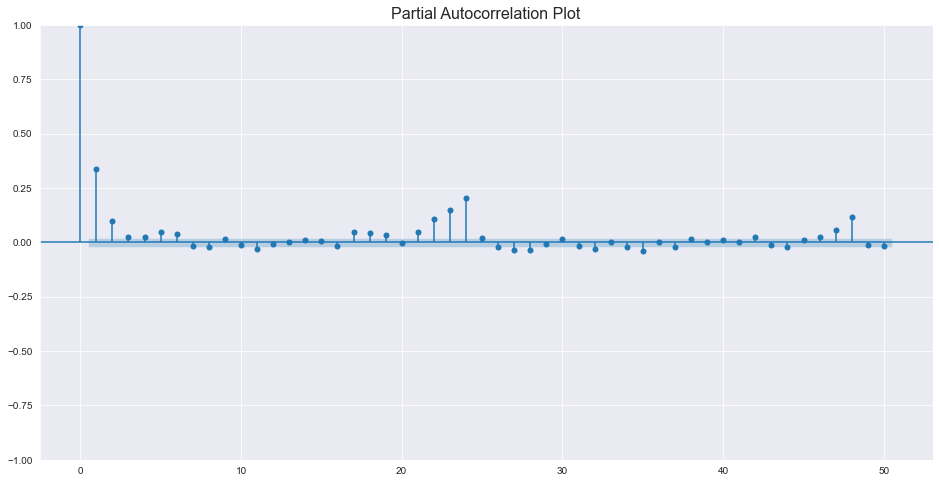

In [55]:
fig, ax = plt.subplots(figsize=(16, 8))
plot_pacf(nb_training_results.resid_response, lags=50, ax=ax)
ax.set_title(label="Partial Autocorrelation Plot", fontsize=16)
plt.show()

How to Handle Autocorrelation

If you reject the null hypothesis and conclude that autocorrelation is present in the residuals, then you have a few different options to correct this problem if you deem it to be serious enough:

1. For positive serial correlation, consider adding lags of the dependent and/or independent variable to the model.

2. For negative serial correlation, check to make sure that none of your variables are overdifferenced.

3. For seasonal correlation, consider adding seasonal dummy variables to the model.

***

<div class="alert alert-block alert-info">
<b>Time series modeling</b> allows us to replicate every element of the process by decomposing the mathematical process into a combination of <u>signals</u> (e.g. growth in demand, seasonal variability, etc) and <u>noise</u> (random probabilistic processes), withou necessarily knowing the underlying causes for each.
</div>

> https://medium.com/swlh/multi-linear-regression-using-python-44bd0d10082d

### Considerations
- Count has a fixed range due to limitation on bikes available. (e.g. we cannot have more than 30 rentals if Moby Bikes only has 30 bikes available and to a new rental begins the bike needs to become available (current rental finished))
- The duration of rentals is relevant and directly impacts the number of rentals per day.
- Because we have a limited range of occurence on our target feature, decisions trees can be applied as they can only predict within the training range.
- Hourly data requires an approach which can count with autocorrelation. Temperature, Humidity and Wind Speed are not randomly throughout the hours. If one hour we have a temperature of 25C, on the next hour is very likely that temperature will be closed to that. (time series?)
- Capturing the relationship on these variables as continuous can be hard for machine learning algorithms as the range is to high. Temperature of 13.4C and 13.9C or 13C and 15C, are practically the same if you think about deciding whether to go bicicling or not. The same rule applies for humidity and wind speed. Transforming these variables into categoricals can provide more relevance to the algorithms.

```python
# Stacking Random Forest and GBM
rf_pred = predict_on_test_set(rf_model, rf_cols)
gbm_pred = predict_on_test_set(gbm_model, gbm_cols)
# taking weighted average of output from two models
y_pred = np.round(.20*rf_pred + .80*gbm_pred)
```
- Consider transforming all features into categories or merge all into one (e.g. good weather = high temperature + weak wind speed + light or no rain). 
```python
df['ideal'] = df[['temp', 'windspeed']].apply(lambda x: (0, 1)[x['temp'] > 27 and x['windspeed'] < 30], axis = 1)
df['sticky'] = df[['humidity', 'workingday']].apply(lambda x: (0, 1)[x['workingday'] == 1 and x['humidity'] >= 60], axis = 1)
```

### Unusual Observations (Outliers) and High Leverage Observations
- We have a few outliers but not sure if they can be treated as inacurates as they capture the data.
- High Leverage Observations are unusual values on the predictors that can dramatically affect the model.

Influencial Points (not all unusual observations have much of an impact on the model) - https://www.kirenz.com/post/2021-11-14-linear-regression-diagnostics-in-python/linear-regression-diagnostics-in-python/

- If we take the log(count), RMSLE can be computed with:
```python
def get_rmsle(y_pred, y_actual):
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)
```

<img title="GitHub Mark" src="./img/GitHub-Mark-64px.png" style="height: 32px; padding-right: 15px" alt="GitHub Mark" align="left"> [GitHub repository](https://github.com/pessini/moby-bikes) <br>Author: Leandro Pessini